In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
df = pd.read_csv('Q3_winequalityN.csv').dropna()
df.head(5)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
le = LabelEncoder()
y = le.fit_transform(df['type'])
X = df.drop('type', axis=1).values
X.shape

(6463, 12)

In [4]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

## 1. Sequential Forward Selection

In [5]:
def select_next_best_index(selected):

    best_index = None
    best_accuracy = 0.0

    for i in range(X_train.shape[1]):

        if i in selected:
            continue

        indices = selected[:]
        indices.append(i)
        X_train_selected = X_train[:, indices]
        X_val_selected = X_val[:, indices]

        clf = LogisticRegression(solver='liblinear')
        clf.fit(X_train_selected, y_train)

        y_val_pred = clf.predict(X_val_selected)
        accuracy = accuracy_score(y_val, y_val_pred)

        if accuracy > best_accuracy:
            best_index = i
            best_accuracy = accuracy
    
    return best_index

In [6]:
def sequential_forward_selection(n):
    selected = []

    while len(selected) < n:
        best_index = select_next_best_index(selected)
        selected.append(best_index)
    
    return selected

In [7]:
selected_indices = sequential_forward_selection(2)
print("Selected feature indices: ", selected_indices)
X_selected = X[:, selected_indices]

Selected feature indices:  [6, 1]


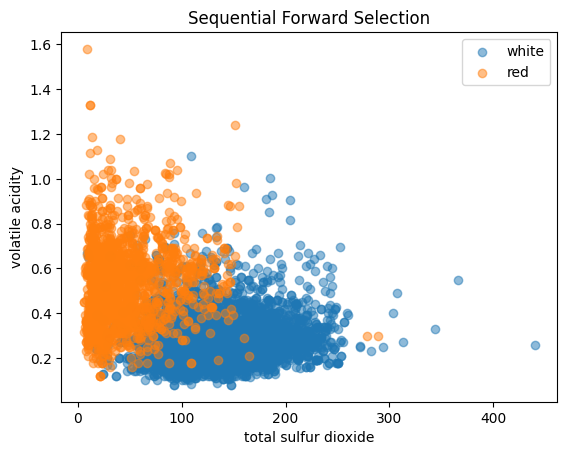

In [8]:
plt.scatter(X_selected[:, 0][y == 1], X_selected[:, 1][y == 1], alpha=0.5)
plt.scatter(X_selected[:, 0][y == 0], X_selected[:, 1][y == 0], alpha=0.5)
plt.xlabel(df.columns[selected_indices[0]+1])
plt.ylabel(df.columns[selected_indices[1]+1])
plt.legend([*le.inverse_transform([1, 0])])
plt.title('Sequential Forward Selection')
plt.show()

## 2. Recursive Backward Elimination

In [9]:
def select_next_worst_index(remaining):

    worst_index = None
    best_accuracy = 0.0
    
    for i in range(X_train.shape[1]):

        if i not in remaining:
            continue

        indices = remaining[:]
        indices.remove(i)
        X_train_removed = X_train[:, indices]
        X_val_removed = X_val[:, indices]

        clf = LogisticRegression(solver='liblinear')
        clf.fit(X_train_removed, y_train)

        y_val_pred = clf.predict(X_val_removed)
        accuracy = accuracy_score(y_val, y_val_pred)

        if accuracy > best_accuracy:
            worst_index = i
            best_accuracy = accuracy
    
    return worst_index

In [10]:
def recursive_feature_elimination(n):
    remaining = list(range(X_train.shape[1]))
    
    while len(remaining) > n:
        worst_index = select_next_worst_index(remaining)
        remaining.remove(worst_index)
    
    return remaining

In [11]:
remaining_indices = recursive_feature_elimination(2)
print("Remaining feature indices: ", remaining_indices)
X_remaining = X[:, remaining_indices]

Remaining feature indices:  [1, 6]


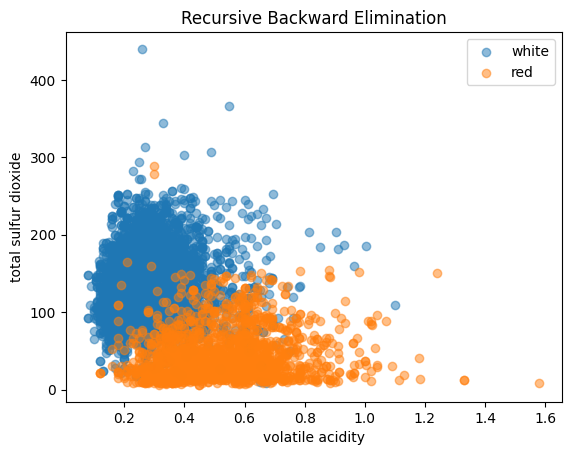

In [12]:
plt.scatter(X_remaining[:, 0][y == 1], X_remaining[:, 1][y == 1], alpha=0.5)
plt.scatter(X_remaining[:, 0][y == 0], X_remaining[:, 1][y == 0], alpha=0.5)
plt.xlabel(df.columns[remaining_indices[0]+1])
plt.ylabel(df.columns[remaining_indices[1]+1])
plt.legend([*le.inverse_transform([1, 0])])
plt.title('Recursive Backward Elimination')
plt.show()

## 3. Comparison

In [13]:
def evaluate(feature_indices):
    X_train_selected = X_train[:, feature_indices]
    X_val_selected = X_val[:, feature_indices]

    clf = LogisticRegression(solver='liblinear')
    clf.fit(X_train_selected, y_train)

    y_val_pred = clf.predict(X_val_selected)
    return accuracy_score(y_val, y_val_pred)

In [14]:
selected = []
accuracies = []

while len(selected) < X.shape[1]:
    best_index = select_next_best_index(selected)
    selected.append(best_index)

    accuracy = evaluate(selected)
    accuracies.append(accuracy)

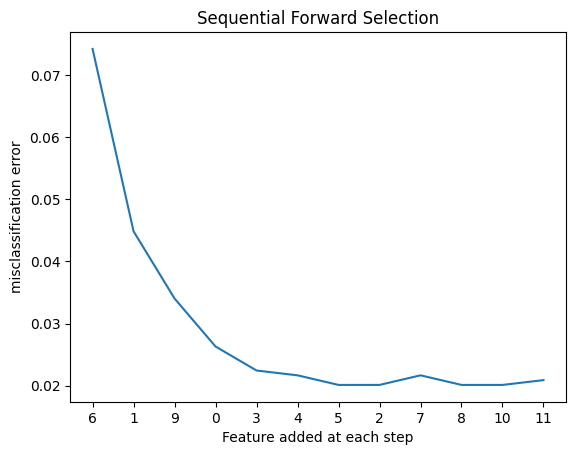

In [15]:
misclassification_error = 1.0 - np.array(accuracies)
plt.plot(np.arange(12), misclassification_error)
plt.xticks(np.arange(12), [str(i) for i in selected])
plt.title('Sequential Forward Selection')
plt.xlabel('Feature added at each step')
plt.ylabel('misclassification error')
plt.show()

In [16]:
remaining = list(range(X_train.shape[1]))
removed = []
accuracies = []
    
while len(remaining) > 1:
    accuracy = evaluate(remaining)
    accuracies.append(accuracy)

    worst_index = select_next_worst_index(remaining)
    removed.append(worst_index)
    remaining.remove(worst_index)

accuracy = evaluate(remaining)
accuracies.append(accuracy)
removed.append(remaining[0])

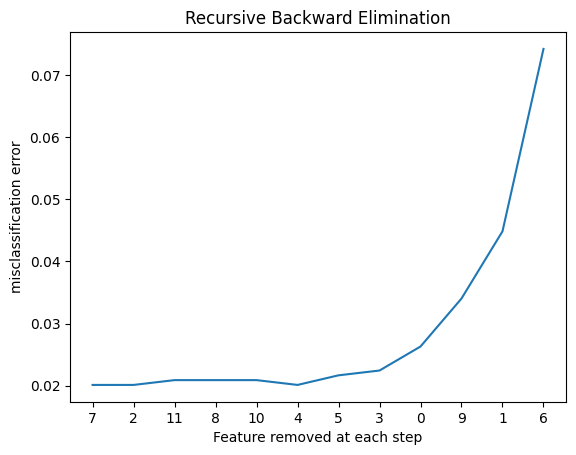

In [17]:
misclassification_error = 1.0 - np.array(accuracies)
plt.plot(np.arange(12), misclassification_error)
plt.xticks(np.arange(12), [str(i) for i in removed])
plt.title('Recursive Backward Elimination')
plt.xlabel('Feature removed at each step')
plt.ylabel('misclassification error')
plt.show()